In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

# VARIABILI
csvfile = 'csv/alldata.csv'
distance_param = 'CDistance'

# LETTURA DATI
tragitti = pd.read_csv(csvfile, index_col=False)
pre_lock_cond = (tragitti['Month'] == 3) & (tragitti['Day'] <= 12)
post_lock_cond = ((tragitti['Month'] == 5) & (tragitti['Day'] >= 4)) | (tragitti['Month'] > 5)
tragitti = tragitti[post_lock_cond]

def clean(df):
    distance_cond = df[distance_param] > 0
    moovit_cond = df['Public'] > 12
    public_cond = df['Public'] > 0
    bike_cond = df['Bike'] > 0
    foot_cond = df['Foot'] > 0
    car_cond = df['Car'] > 0
    car2go_cond = df['Car2Go'] > 0
    enjoy_cond = df['Enjoy'] > 0
    coherence_cond = (df['Car'] <= df['Car2Go']) & (df['Car'] <= df['Enjoy'])
    cleaned = distance_cond & public_cond & bike_cond & foot_cond & car_cond & car2go_cond & enjoy_cond & coherence_cond
    return cleaned

In [2]:
tragitti = tragitti[clean(tragitti)]

center_point = (45.464216, 9.191949)
point_onepointfive_km_far = (45.463878, 9.208735)
center_point_radius = math.sqrt(
    (point_onepointfive_km_far[0] - center_point[0])**2. +
    (point_onepointfive_km_far[1] - center_point[1])**2.) # 1.5 km di raggio dal duomo di milano

def pass_through_center(tratta):
    start_point = tratta[0]
    end_point = tratta[1]
    medium_point = (float(start_point[0] + end_point[0]) / 2., float(start_point[1] + end_point[1]) / 2.)
    
    if ((medium_point[0] - center_point[0])**2. + (medium_point[1] - center_point[1])**2. <= center_point_radius**2.):
        return True
    else:
        return False    

In [3]:
propertydf = tragitti.apply(lambda p: pass_through_center(((p['Lat'], p['Lon']), (p['Elat'], p['Elon']))), axis=1)

In [4]:
len(tragitti)

49560

In [5]:
len(tragitti[propertydf == True])

23901

In [6]:
len(tragitti[propertydf == False])

25659

In [7]:
# Velocita' media durante il giorno
def vmedia_giorno(df, mezzo):
    ore = range(7, 24)
    vmedia_giorno_ore = []
    for ora in ore:
        tragitti_fascia_oraria = df[df['Hour'] == ora]
        velocita_media_oraria = (tragitti_fascia_oraria[distance_param] * 60.) / tragitti_fascia_oraria[mezzo]
        vmedia_giorno_ore.append(velocita_media_oraria.mean())
    return vmedia_giorno_ore
    
def vmedia_week(df, mezzo):
    short_paths = df[distance_param].between(2.0, 6.0)
    long_paths = df[distance_param].between(6.0, 10.0)
    
    lst = [
        vmedia_giorno(df[short_paths & (propertydf == True)], mezzo),
        vmedia_giorno(df[long_paths & (propertydf == True)], mezzo),
        vmedia_giorno(df[short_paths & (propertydf == False)], mezzo),
        vmedia_giorno(df[long_paths & (propertydf == False)], mezzo)]
    
    array = np.array(lst).T
    
    return pd.DataFrame(array, index=range(7,24), columns=[
        '[2, 6) km centro', '[6, 10) km centro',
        '[2, 6) km fuori', '[6, 10) km fuori']).round(2)

wcolors = ['dodgerblue', 'royalblue', 'lightcoral', 'tomato']

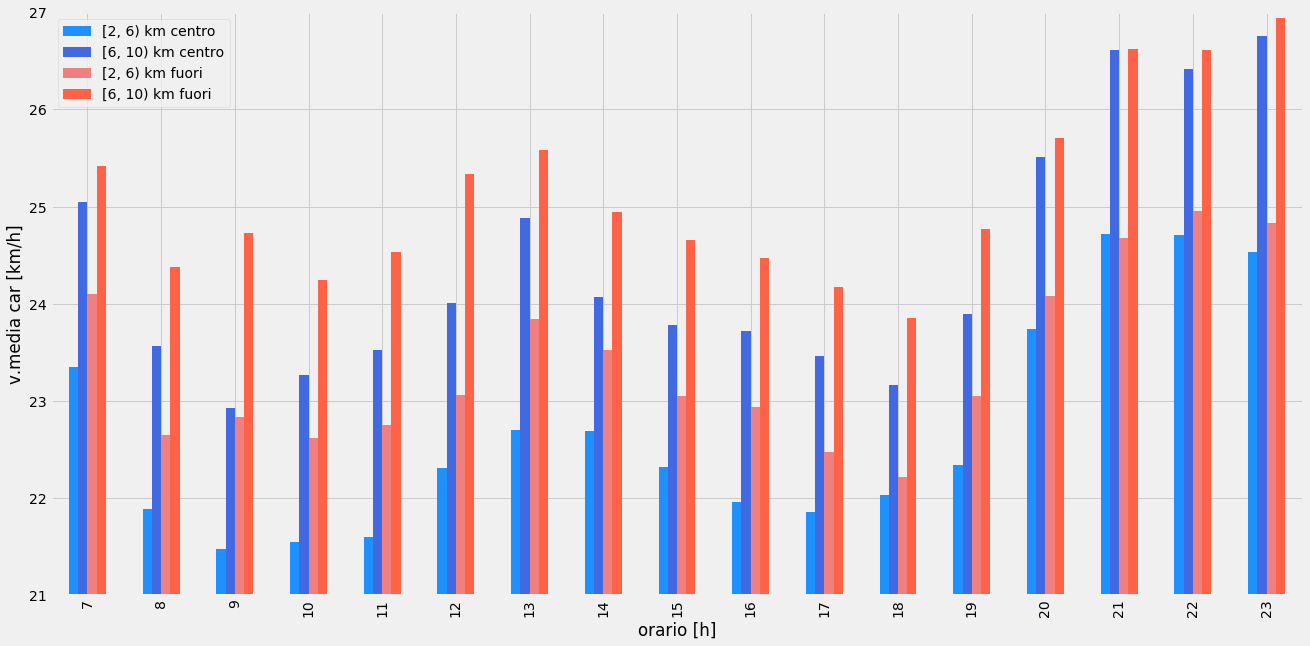

In [8]:
plt.rc('figure', figsize=((20, 10)))
vmedia_week(tragitti, 'Car').plot.bar(color=wcolors)
plt.ylim(21, 27)
plt.xlabel('orario [h]')
plt.ylabel('v.media car [km/h]')
plt.show()